In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = 'cuda'

## Here we simply predict the next step in the sequence. Each model is trained on 1/4 of the data

In [3]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [4]:
torch.manual_seed(42)

In [5]:
def MARE(prediction_tensor, truth_tensor):
    epsilon = 1e-8  # Small value to prevent division by zero
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)) / torch.abs(truth_tensor + epsilon)) / truth_tensor.numel()

In [6]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [7]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

In [8]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [9]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [10]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [11]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [12]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device=device)  # (batch, output_dim)


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

# criterion2 = nn.SmoothL1Loss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
# criterion3 = nn.SmoothL1Loss()
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [14]:
train_seq_tensor1.shape

torch.Size([142, 12, 1])

In [15]:
val_seq_tensor1.shape

torch.Size([27, 12, 1])

In [16]:
first_piece.shape

(193, 1)

In [17]:
len(train_seq_tensor1)

142

In [18]:
train_seq_tensor1[0].shape

torch.Size([12, 1])

In [19]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = criterion1(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    model1.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model1(val_seq_tensor1[i])
                val_loss = criterion1(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.09611762315034866, Val Loss: 0.15314573049545288
Epoch 10, Train Loss: 1.3003844287595712e-05, Val Loss: 0.003270655870437622
Epoch 20, Train Loss: 6.937117632332956e-06, Val Loss: 0.0015851428033784032
Epoch 30, Train Loss: 0.003579051699489355, Val Loss: 0.006157807540148497
Epoch 40, Train Loss: 0.006437377538532019, Val Loss: 0.00776266073808074
Epoch 50, Train Loss: 0.007799139246344566, Val Loss: 0.008874922059476376
Epoch 60, Train Loss: 0.0017208352219313383, Val Loss: 0.0013735918328166008
Epoch 70, Train Loss: 0.004446686245501041, Val Loss: 0.004525898490101099
Epoch 80, Train Loss: 0.000871594063937664, Val Loss: 0.00022193233598954976
Epoch 90, Train Loss: 0.003582047764211893, Val Loss: 0.002168049803003669


### Check model 1 on dataset 1 performance

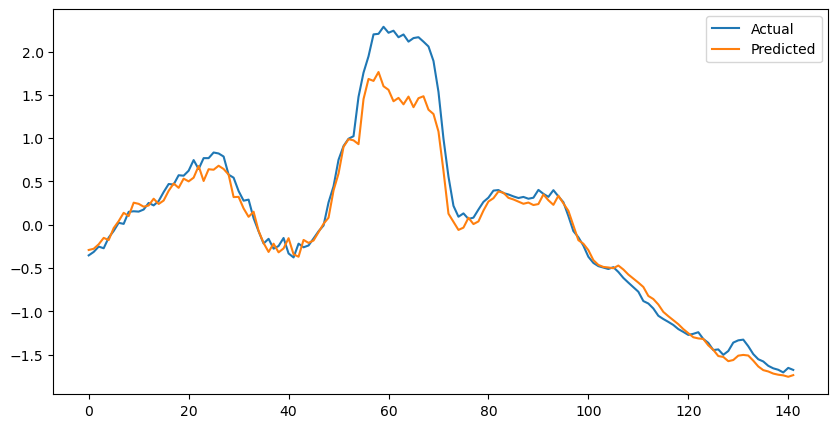

In [20]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(train_seq_tensor1)):
        pred = model1(train_seq_tensor1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [21]:
train_label_tensor1.squeeze(1).shape

torch.Size([142])

In [22]:
torch.FloatTensor(y_pred).to(device=device).shape

torch.Size([142])

In [23]:
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), train_label_tensor1)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), train_label_tensor1).item()

MARE: 0.34837979078292847
MSE: 0.05766195431351662


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([142, 1])) that is different to the input size (torch.Size([142])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.6792672872543335

In [24]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

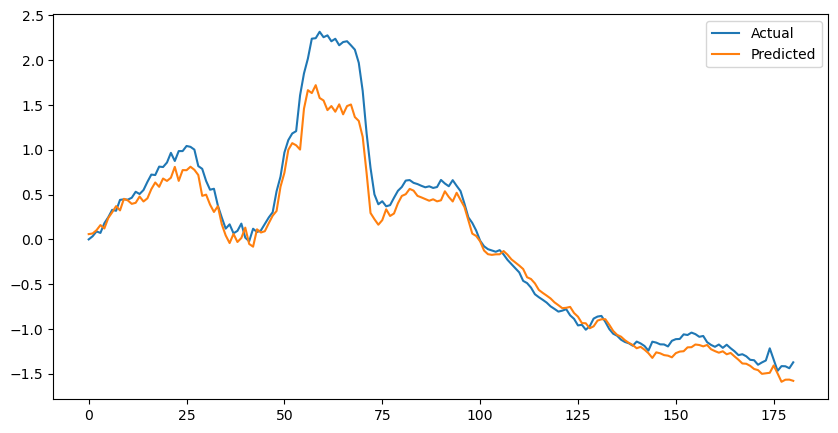

In [25]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model1(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [26]:
# unnormalize the data to compute accurate MARE
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values

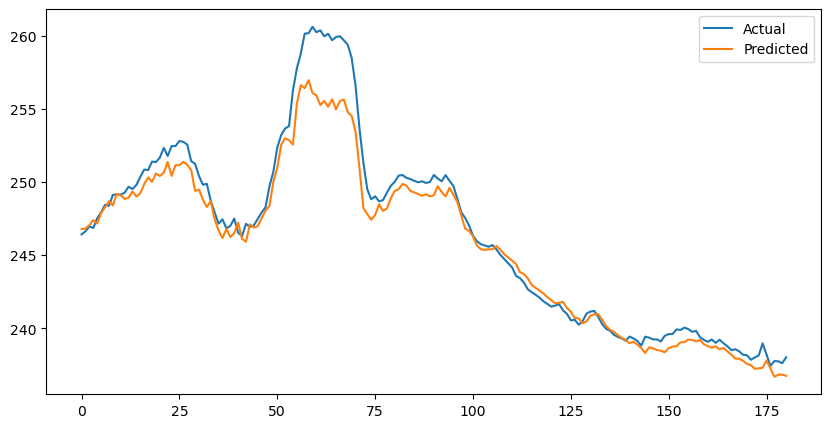

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [28]:
print(f'MARE: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.003858036714738269
MSE: 0.057865533977746964


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.70358806848526

## Now let's test on datasets 2, 3, 4

### First create test set 2

In [29]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

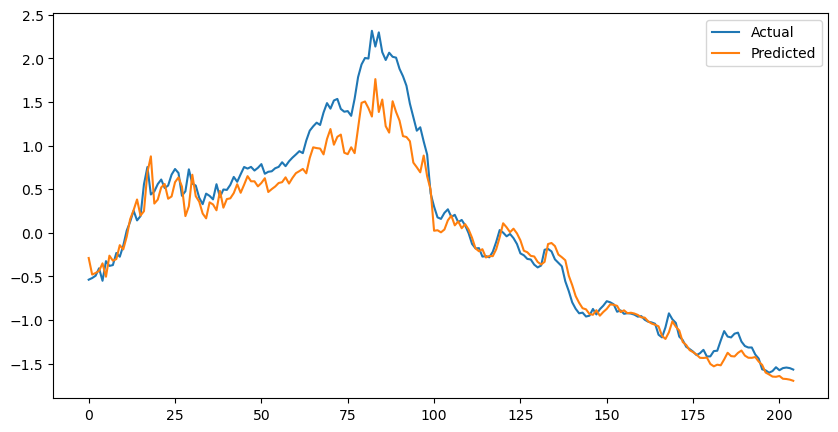

In [30]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model1(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [31]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values

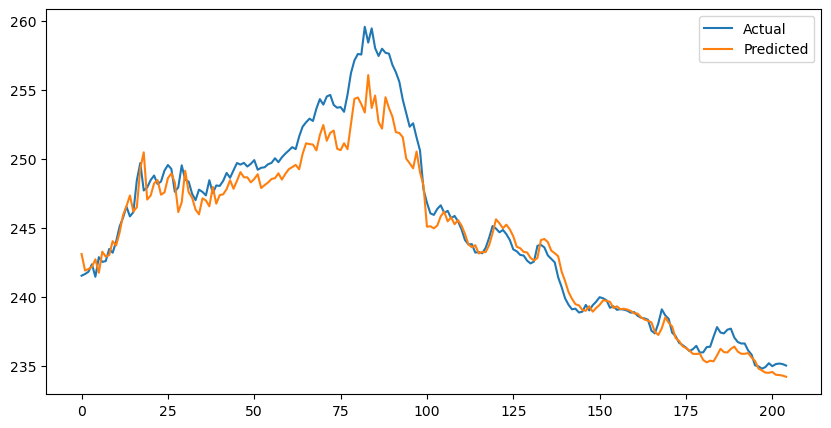

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [33]:
print(f'MARE: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2)

MARE: 0.004476143266433301
MSE: 0.06505649536848068


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([205, 1])) that is different to the input size (torch.Size([205])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.6991, device='cuda:0')

### Now dataset 3

In [34]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

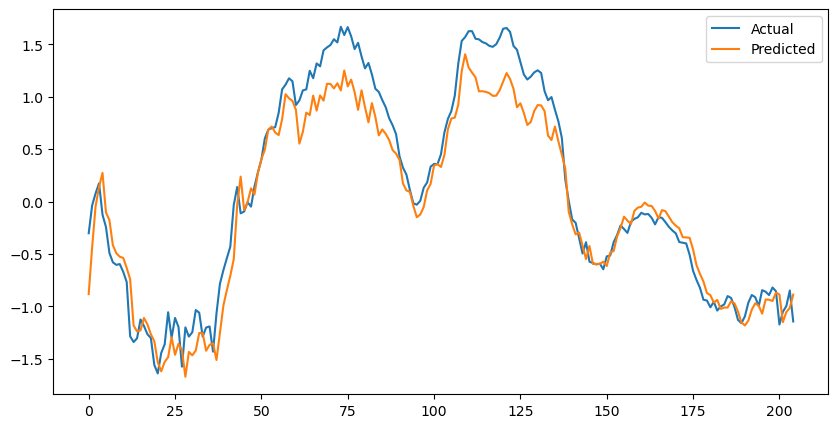

In [35]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model1(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

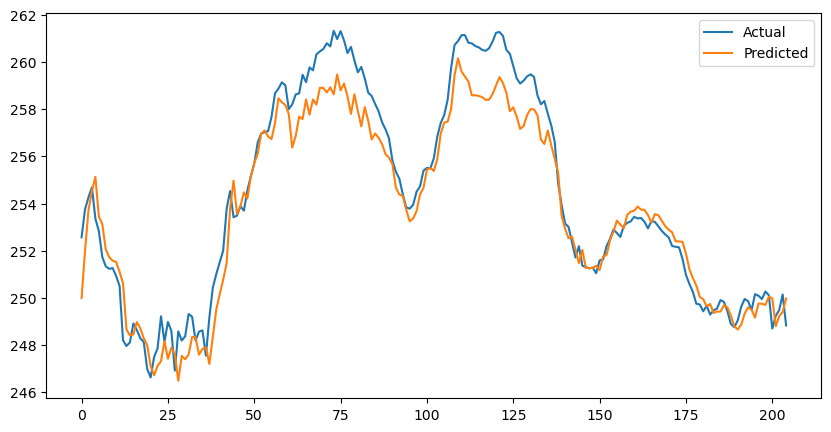

In [36]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [37]:
print(f'MARE: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3)

MARE: 0.0035540813728838026
MSE: 0.06780090183019638


tensor(0.6636, device='cuda:0')

### Finally Dataset 4

In [38]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

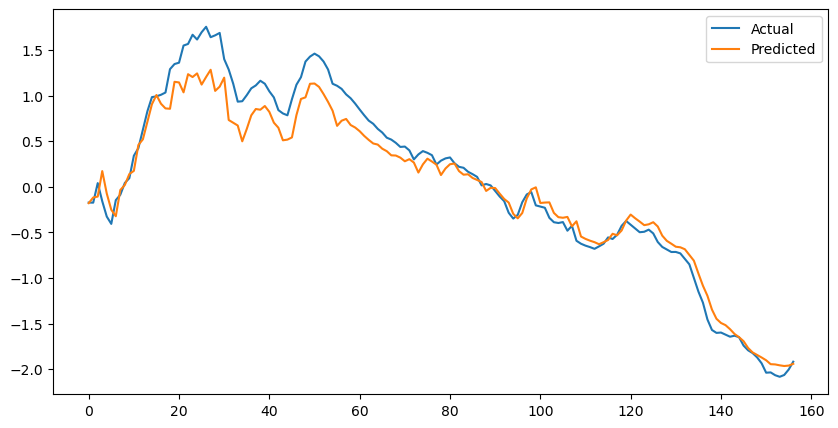

In [39]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model1(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

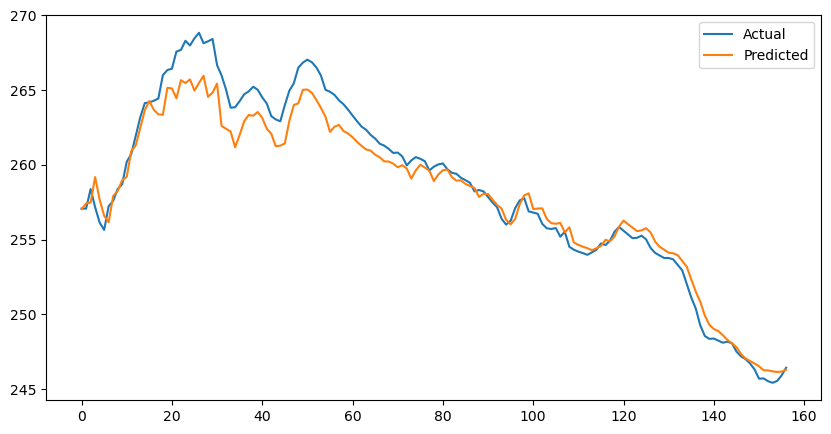

In [40]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [41]:
print(f'MARE: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4)

MARE: 0.0038413065229983855
MSE: 0.04672980308532715


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([157, 1])) that is different to the input size (torch.Size([157])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.6624, device='cuda:0')

## Now we train Model 2 on Dataset 2

In [42]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device=device)  # (batch, output_dim)

In [43]:
second_piece.shape

(217, 1)

In [44]:
train_seq_tensor2.shape

torch.Size([161, 12, 1])

In [45]:
val_seq_tensor2.shape

torch.Size([32, 12, 1])

In [46]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to(device)  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

In [47]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model2.train()
    
        optimizer2.zero_grad()
        y_pred = model2(train_seq_tensor2[i])
        loss = criterion2(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer2.step()
    
        train_losses.append(loss.item())

    # Validation
    model2.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model2(val_seq_tensor2[i])
                val_loss = criterion2(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9607878923416138, Val Loss: 1.6249792575836182
Epoch 10, Train Loss: 0.00585570465773344, Val Loss: 0.18040822446346283
Epoch 20, Train Loss: 0.0007167182629927993, Val Loss: 0.047640252858400345
Epoch 30, Train Loss: 0.006731685250997543, Val Loss: 0.008633683435618877
Epoch 40, Train Loss: 0.008708140812814236, Val Loss: 0.003251372603699565
Epoch 50, Train Loss: 0.006688681431114674, Val Loss: 0.0029700943268835545
Epoch 60, Train Loss: 0.0022107886616140604, Val Loss: 0.010858481749892235
Epoch 70, Train Loss: 0.0008165049948729575, Val Loss: 0.03277173265814781
Epoch 80, Train Loss: 0.0008254655404016376, Val Loss: 0.01733315922319889
Epoch 90, Train Loss: 0.00034126907121390104, Val Loss: 0.030009610578417778


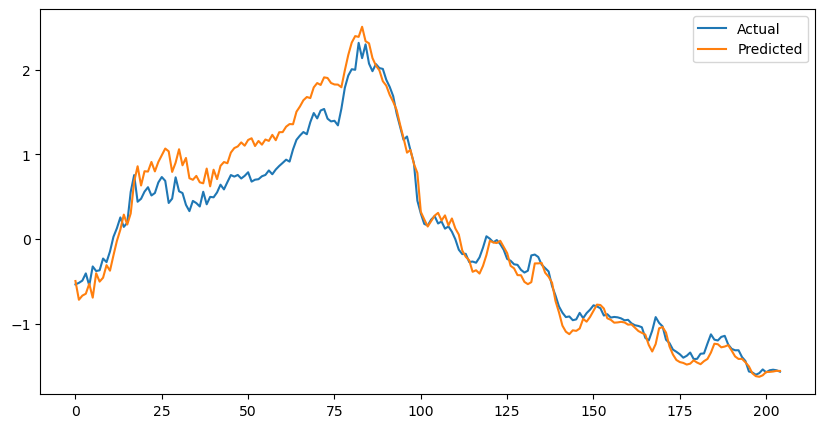

In [48]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model2(test_tensor_seq_2[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

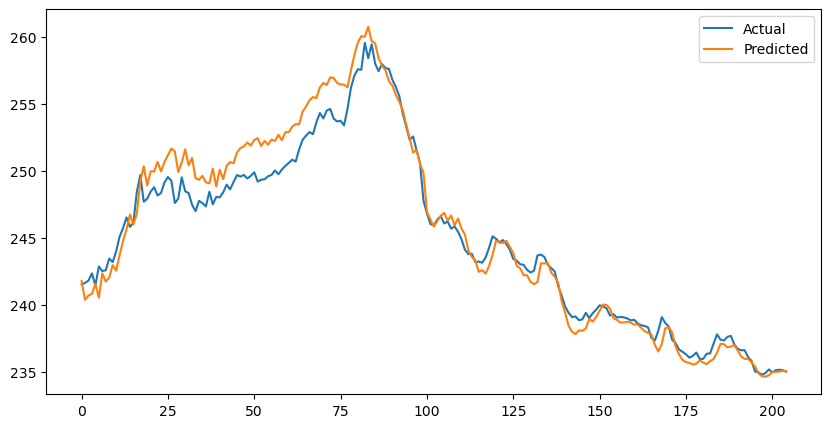

In [49]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [50]:
print(f'MARE: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion1(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 0.0043090054423008586
MSE: 0.05011003464460373


0.8437831401824951

### Test on dataset 1

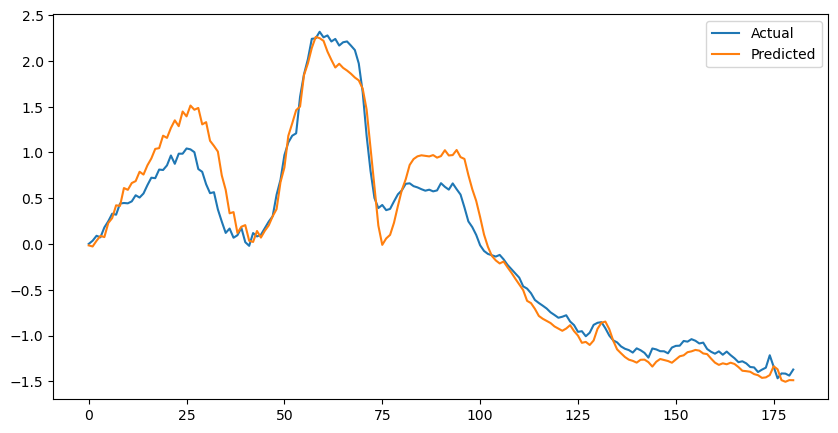

In [51]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model2(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

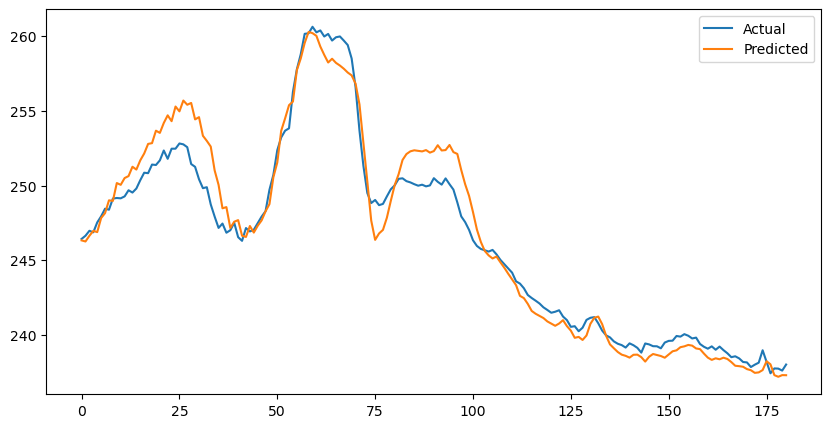

In [52]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [53]:
print(f'MARE: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.0043526537672991744
MSE: 0.05361728370189667


0.8194700479507446

### Dataset 3

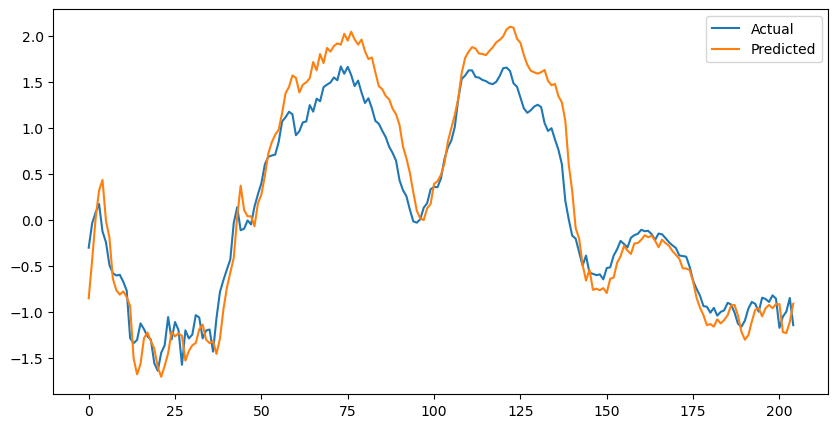

In [54]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model2(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

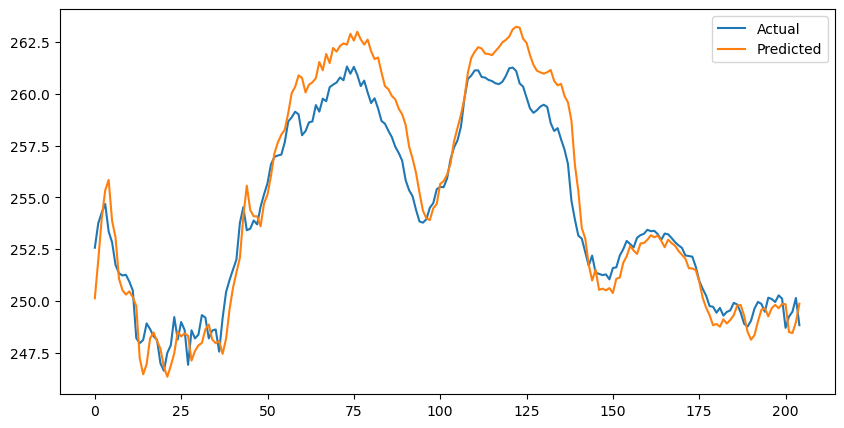

In [55]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [56]:
print(f'MARE: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 0.004305421157376507
MSE: 0.09400255233049393


0.8495794534683228

### Dataset 4

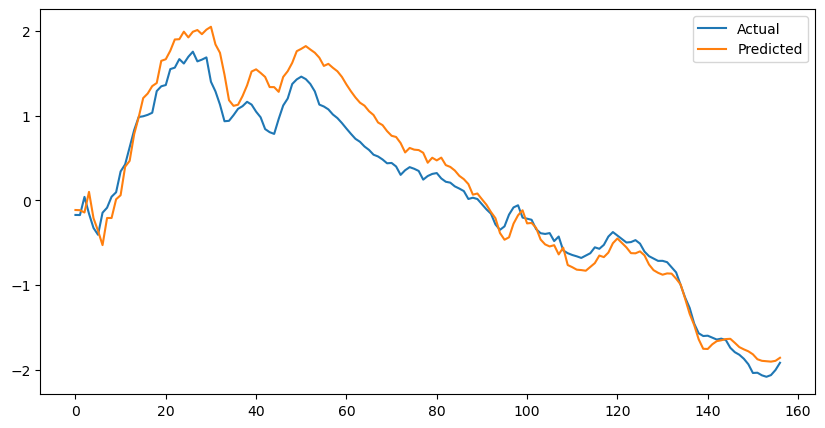

In [57]:
model2.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model2(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

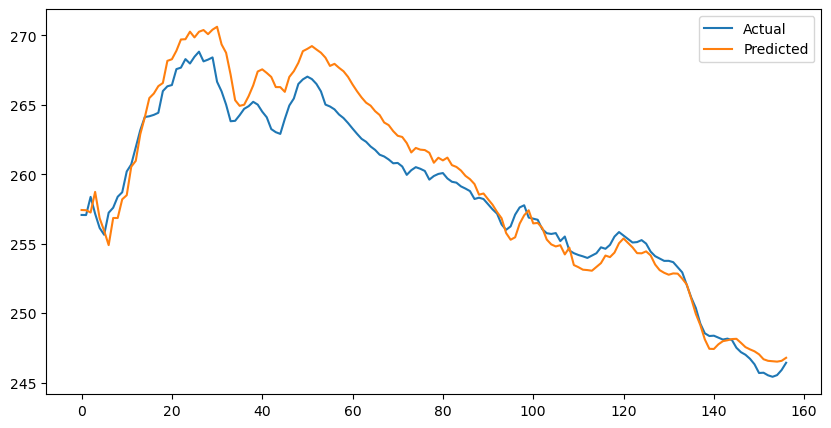

In [58]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [59]:
print(f'MARE: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.005144020126639662
MSE: 0.07514117658138275


0.8439778685569763

### Now train Model 3 on dataset 3

In [60]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [61]:
third_piece.shape

(217, 1)

In [62]:
train_seq_tensor3.shape

torch.Size([161, 12, 1])

In [63]:
val_seq_tensor3.shape

torch.Size([32, 12, 1])

In [64]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device='cuda')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
criterion3 = nn.SmoothL1Loss()

In [65]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor3)):
        model3.train()
    
        optimizer3.zero_grad()
        y_pred = model3(train_seq_tensor3[i])
        loss = criterion3(y_pred, train_label_tensor3[i])
        # print(loss.item())
        loss.backward()
        optimizer3.step()
    
        train_losses.append(loss.item())

    # Validation
    model3.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor3)):
                y_val = model3(val_seq_tensor3[i])
                val_loss = criterion3(y_val, val_label_tensor3[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.056679628789424896, Val Loss: 0.7692420482635498
Epoch 10, Train Loss: 0.0010632001794874668, Val Loss: 0.10321308672428131
Epoch 20, Train Loss: 5.468764356919564e-06, Val Loss: 0.0715925469994545
Epoch 30, Train Loss: 4.05029823014047e-05, Val Loss: 0.1065441370010376
Epoch 40, Train Loss: 9.732855687616393e-05, Val Loss: 0.12221778184175491
Epoch 50, Train Loss: 0.0003981597546953708, Val Loss: 0.07852094620466232
Epoch 60, Train Loss: 1.82849689736031e-05, Val Loss: 0.0761522650718689
Epoch 70, Train Loss: 3.119605025858618e-05, Val Loss: 0.07317783683538437
Epoch 80, Train Loss: 8.383816748391837e-05, Val Loss: 0.06803622096776962
Epoch 90, Train Loss: 0.00012653274461627007, Val Loss: 0.06856002658605576


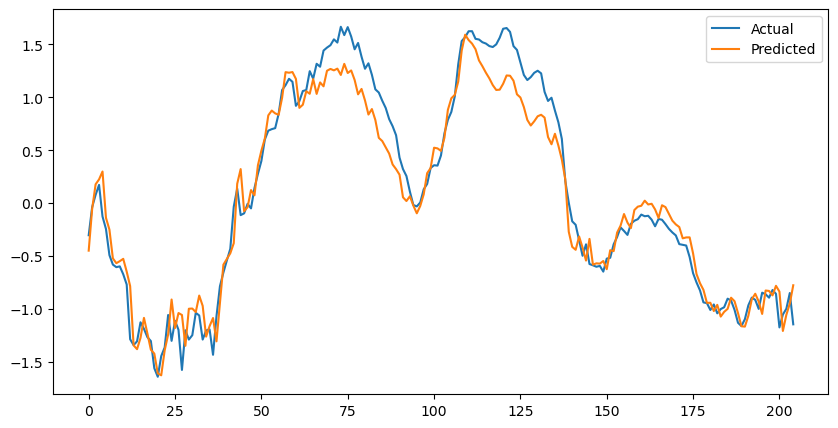

In [66]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model3(test_tensor_seq_3[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

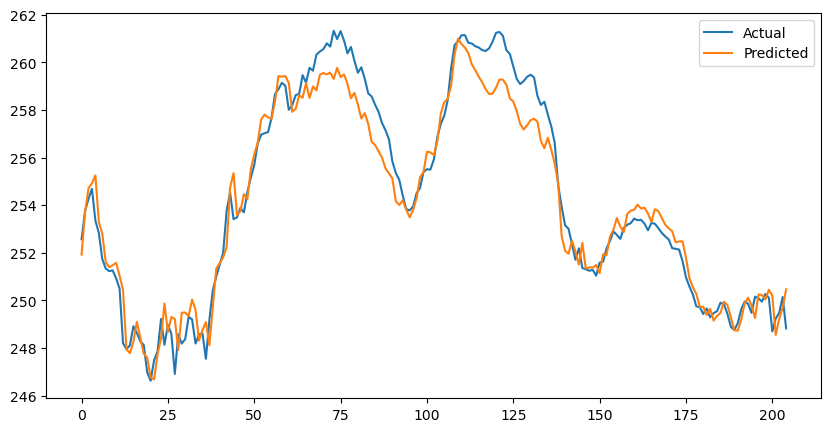

In [67]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [68]:
print(f'MARE: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 0.0029615490331562945
MSE: 0.04780098423361778


0.6652265191078186

### Test on dataset 1

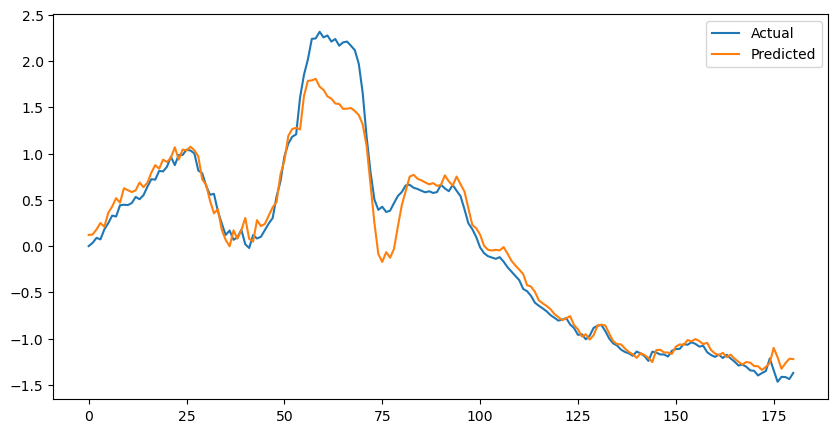

In [69]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model3(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

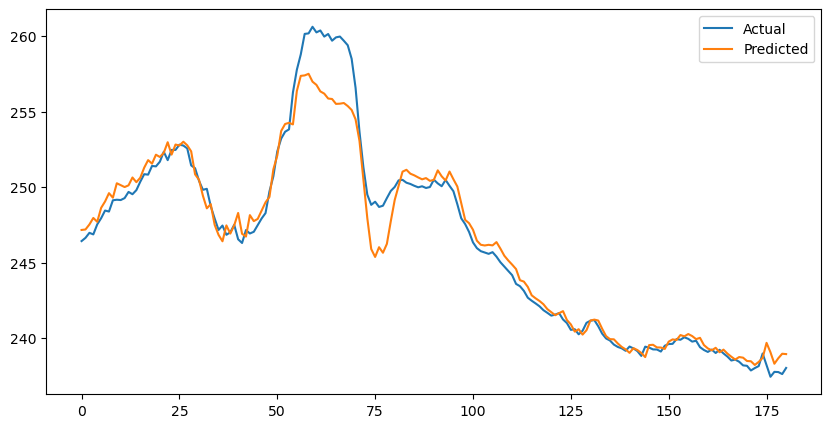

In [70]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [71]:
print(f'MARE: {MARE_np(y_hat,test_labels_1_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.003334569903030276
MSE: 0.04588346555829048


0.714521050453186

### Test on dataset 2

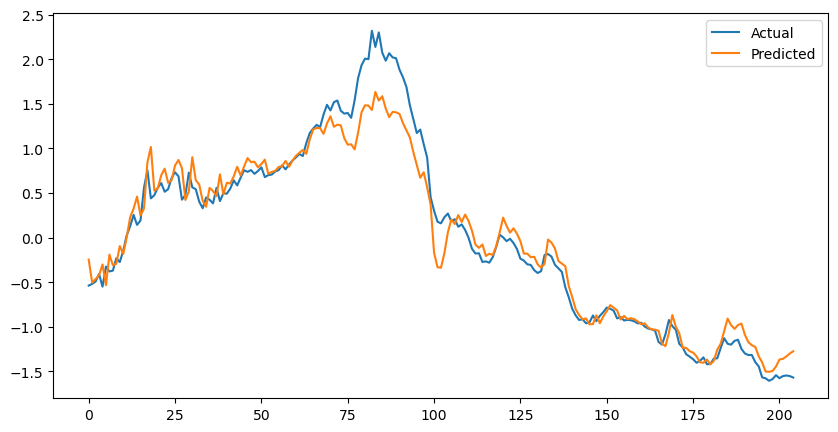

In [72]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model3(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

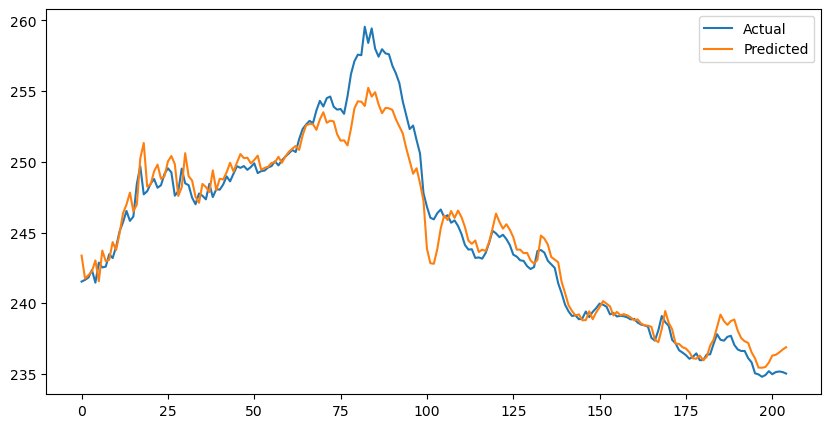

In [73]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [74]:
print(f'MARE: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 0.00412831516069357
MSE: 0.05440004914999008


0.7021318674087524

### Test on dataset 4

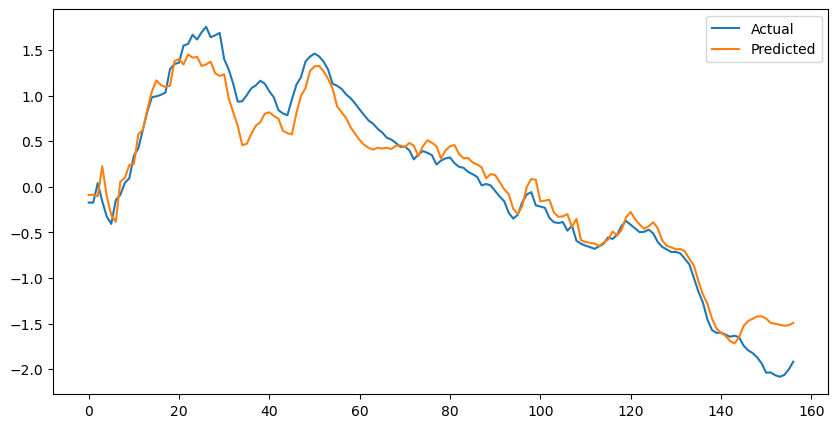

In [75]:
model3.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model3(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

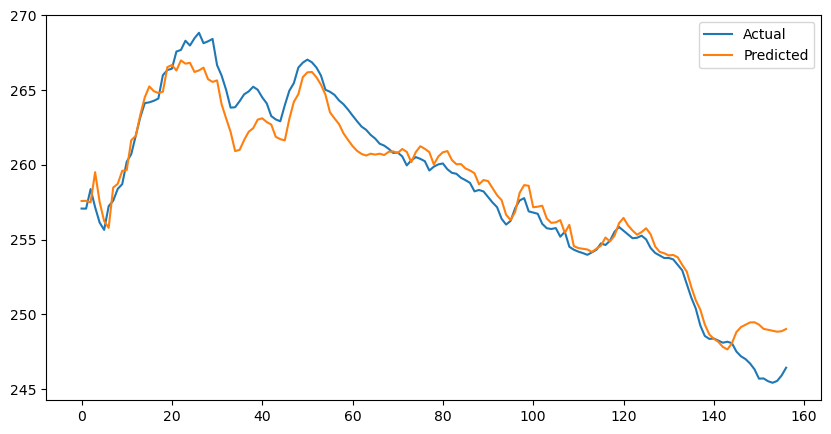

In [76]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [77]:
print(f'MARE: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.004146803289663162
MSE: 0.051984209567308426


0.6634120941162109

## Train model 4 on dataset 4

In [78]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [79]:
fourth_piece.shape

(169, 1)

In [80]:
train_seq_tensor4.shape

torch.Size([123, 12, 1])

In [81]:
val_seq_tensor4.shape

torch.Size([22, 12, 1])

In [82]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
model4.to(device='cuda')

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [83]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor4)):
        model4.train()
    
        optimizer4.zero_grad()
        y_pred = model4(train_seq_tensor4[i])
        loss = criterion4(y_pred, train_label_tensor4[i])
        # print(loss.item())
        loss.backward()
        optimizer4.step()
    
        train_losses.append(loss.item())

    # Validation
    model4.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor4)):
                y_val = model4(val_seq_tensor4[i])
                val_loss = criterion4(y_val, val_label_tensor4[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.45110616087913513, Val Loss: 2.119037628173828
Epoch 10, Train Loss: 0.00021045145695097744, Val Loss: 0.5123978853225708
Epoch 20, Train Loss: 0.008186640217900276, Val Loss: 0.3660043776035309
Epoch 30, Train Loss: 0.0027464840095490217, Val Loss: 0.2744438350200653
Epoch 40, Train Loss: 0.0002507950412109494, Val Loss: 0.21449264883995056
Epoch 50, Train Loss: 2.0269901142455637e-05, Val Loss: 0.19045063853263855
Epoch 60, Train Loss: 0.00011480927787488326, Val Loss: 0.17589162290096283
Epoch 70, Train Loss: 0.0005518374382518232, Val Loss: 0.2059176117181778
Epoch 80, Train Loss: 0.0006607570103369653, Val Loss: 0.20617704093456268
Epoch 90, Train Loss: 0.010188035666942596, Val Loss: 0.34991931915283203


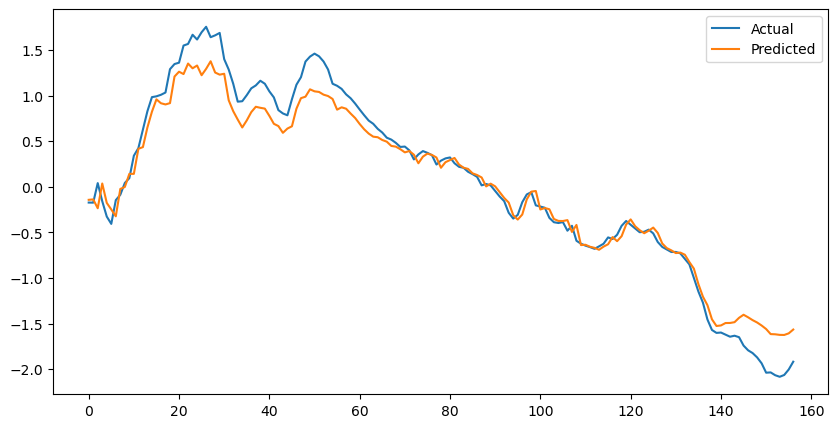

In [84]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = model4(test_tensor_seq_4[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

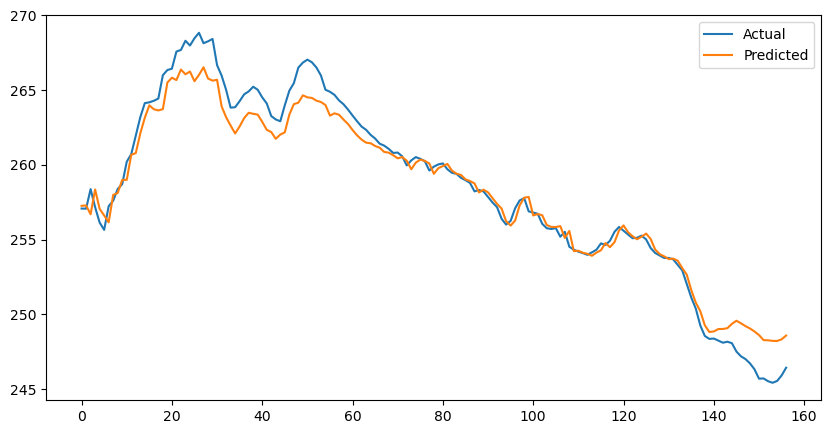

In [85]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [86]:
print(f'MARE: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_4)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4).item()

MARE: 0.0035823454208964256
MSE: 0.04130302369594574


0.6576485633850098

### Test on dataset 1

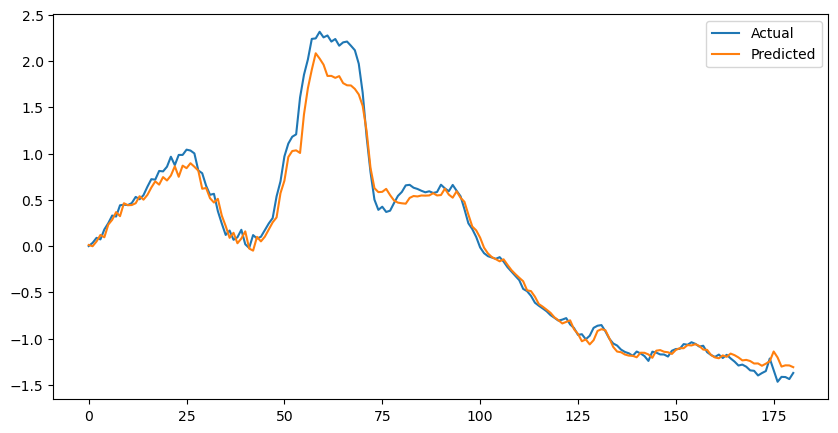

In [87]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = model4(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

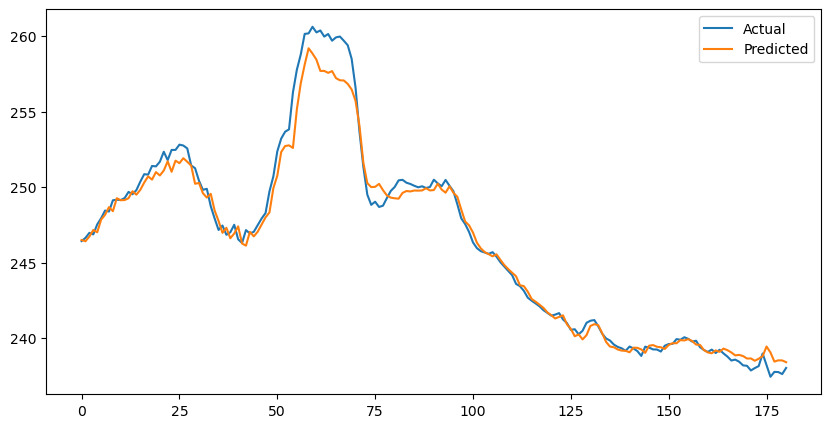

In [88]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [89]:
print(f'MARE: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_1)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1).item()

MARE: 0.0023485091457389577
MSE: 0.021091198548674583


0.7192276120185852

### Test on dataset 2

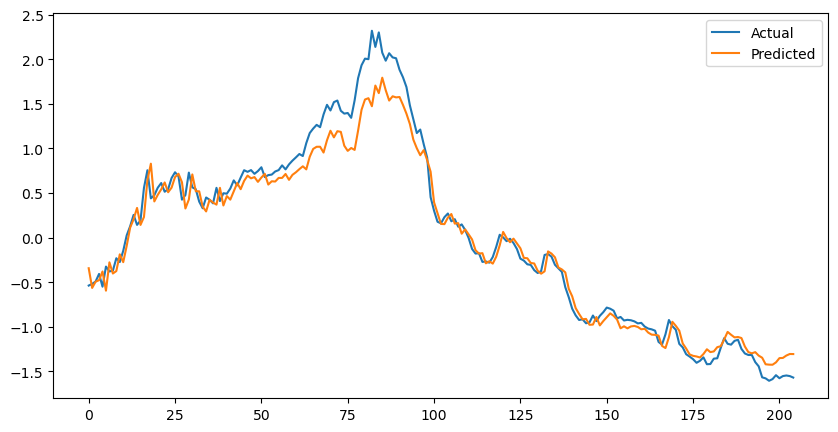

In [90]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = model4(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

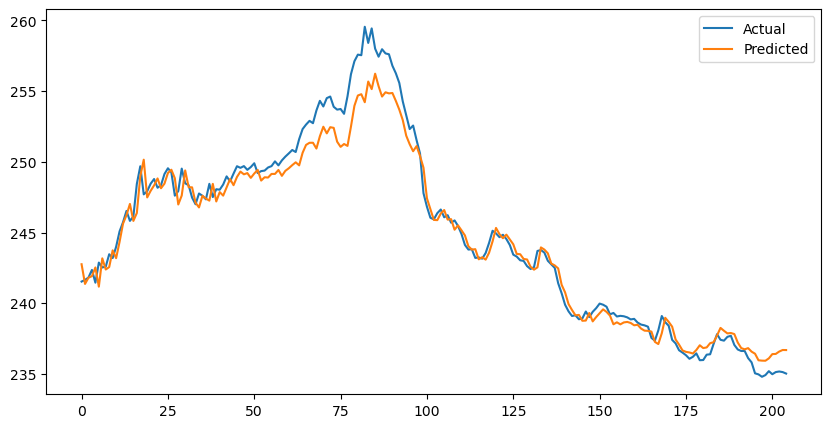

In [91]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [92]:
print(f'MARE: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_2)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2).item()

MARE: 0.0035349050372599873
MSE: 0.03778720647096634


0.6997516751289368

### Test on dataset 3

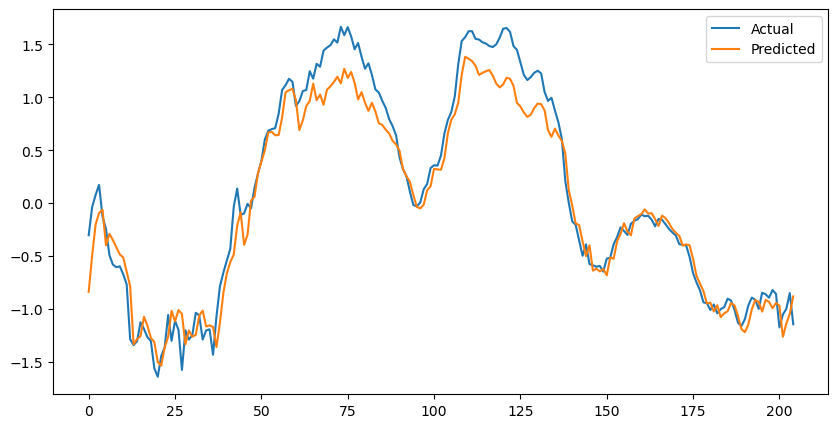

In [93]:
model4.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = model4(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

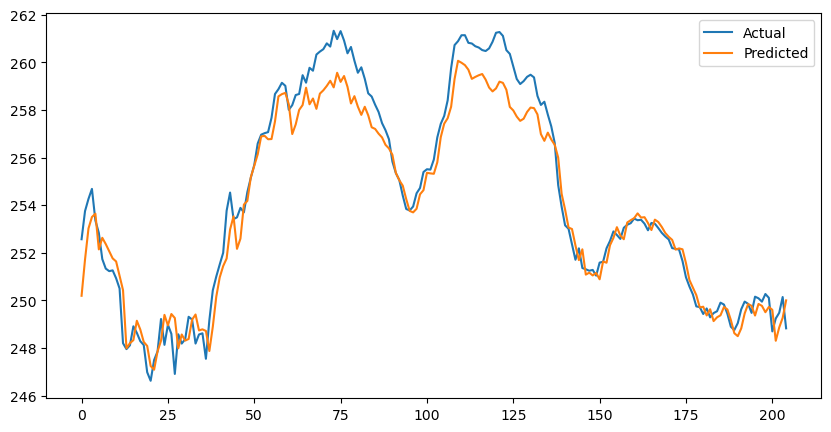

In [94]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [95]:
print(f'MARE: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device=device).unsqueeze(1), test_tensor_labels_3)}')
criterion2(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3).item()

MARE: 0.003032791523625027
MSE: 0.050493933260440826


0.6619507074356079